In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import matplotlib.colors as cl
from matplotlib.colorbar import Colorbar
import seaborn as sns
import pandas as pd
import numpy as np
import glob, joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

In [2]:
tess_list = glob.glob('./targetdata/*_tess.csv')

tess_data = []

for filename in tess_list:
    df = pd.read_csv(filename, index_col=None, header=0)
    tess_data.append(df)
    
tess_data = pd.concat(tess_data, axis=0, ignore_index=True)
tess_data = tess_data.rename(columns={'Santos Period (d)': 'Ground Truth Period (d)'})

In [3]:
kelt_train = pd.read_csv('O17_train.csv')
ktrain_tics = kelt_train['TIC_ID']

In [4]:
kelt_list = glob.glob('./kelt_eleanor/*_eleanor.csv')

kelt_data = []

for filename in kelt_list:
    df = pd.read_csv(filename, index_col=None, header=0)
    try:
        df = df.rename(columns={'KIC': 'ID'})
    except:
        df = df
    if int(df['ID'].values) in ktrain_tics.values:
        kelt_data.append(df)
    
kelt_data = pd.concat(kelt_data, axis=0, ignore_index=True)

In [5]:
combo_data = pd.concat((tess_data, kelt_data), axis=0, ignore_index=True)

In [6]:
kic = combo_data['KIC']
p_r = combo_data['Ground Truth Period (d)']

ls_a = combo_data['LS Period 1st peak (d)']
ls_b = combo_data['LS Period 2nd peak (d)']
ls_c = combo_data['LS Period 3rd peak (d)']
ls_amp_a = combo_data['LS Period 1st amplitude']
ls_amp_b = combo_data['LS Period 2nd amplitude']
ls_amp_c = combo_data['LS Period 3rd amplitude']
ls_rms_a = combo_data['LS Period 1st RMS']
ls_rms_b = combo_data['LS Period 2nd RMS']
ls_rms_c = combo_data['LS Period 3rd RMS']
ls_mad_a = combo_data['LS Period 1st MAD']
ls_mad_b = combo_data['LS Period 2nd MAD']
ls_mad_c = combo_data['LS Period 3rd MAD']
ls2_a = combo_data['LS 2-term Period 1st peak (d)']
ls2_b = combo_data['LS 2-term Period 2nd peak (d)']
ls2_c = combo_data['LS 2-term Period 3rd peak (d)']
ls2_amp_a = combo_data['LS 2-term Period 1st amplitude']
ls2_amp_b = combo_data['LS 2-term Period 2nd amplitude']
ls2_amp_c = combo_data['LS 2-term Period 3rd amplitude']
ls2_rms_a = combo_data['LS 2-term Period 1st RMS']
ls2_rms_b = combo_data['LS 2-term Period 2nd RMS']
ls2_rms_c = combo_data['LS 2-term Period 3rd RMS']
ls2_mad_a = combo_data['LS 2-term Period 1st MAD']
ls2_mad_b = combo_data['LS 2-term Period 2nd MAD']
ls2_mad_c = combo_data['LS 2-term Period 3rd MAD']
acf_a = combo_data['ACF Period 1st peak (d)']
acf_b = combo_data['ACF Period 2nd peak (d)']
acf_c = combo_data['ACF Period 3rd peak (d)']
acf_amp_a = combo_data['ACF Period 1st amplitude']
acf_amp_b = combo_data['ACF Period 2nd amplitude']
acf_amp_c = combo_data['ACF Period 3rd amplitude']
acf_rms_a = combo_data['ACF Period 1st RMS']
acf_rms_b = combo_data['ACF Period 2nd RMS']
acf_rms_c = combo_data['ACF Period 3rd RMS']
acf_mad_a = combo_data['ACF Period 1st MAD']
acf_mad_b = combo_data['ACF Period 2nd MAD']
acf_mad_c = combo_data['ACF Period 3rd MAD']
ls_med = combo_data['LS median power']
ls2_med = combo_data['LS 2-term median power']
rvar = combo_data['Rvar']
cdpp = combo_data['CDPP']

# Vetting for rotation

In [7]:
period_state = [1 if p > 0 else 0 for p in p_r]

In [8]:
features = np.array([ls_a, ls_b, ls_c,
                    ls_amp_a, ls_amp_b, ls_amp_c,
                    ls_rms_a, ls_rms_b, ls_rms_c,
                    ls_mad_a, ls_mad_b, ls_mad_c,
                    ls2_a, ls2_b, ls2_c,
                    ls2_amp_a, ls2_amp_b, ls2_amp_c,
                    ls2_rms_a, ls2_rms_b, ls2_rms_c,
                    ls2_mad_a, ls2_mad_b, ls2_mad_c,
                    acf_a, acf_b, acf_c,
                    acf_amp_a, acf_amp_b, acf_amp_c,
                    acf_rms_a, acf_rms_b, acf_rms_c,
                    acf_mad_a, acf_mad_b, acf_mad_c,
#                     ls_med, rvar, cdpp])#,
                    ls_med, ls2_med, rvar, cdpp])#,
                    #kp_t, teff_t])#, flag_binary_t, flag_koi_t])
feature_names = ['LS Period 1st peak (d)', 'LS Period 2nd peak (d)', 'LS Period 3rd peak (d)',
                 'LS Period 1st amplitude', 'LS Period 2nd amplitude', 'LS Period 3rd amplitude',
                 'LS Period 1st RMS', 'LS Period 2nd RMS', 'LS Period 3rd RMS',
                 'LS Period 1st MAD', 'LS Period 2nd MAD', 'LS Period 3rd MAD',
                 'LS 2-term Period 1st peak (d)', 'LS 2-term Period 2nd peak (d)', 'LS 2-term Period 3rd peak (d)',
                 'LS 2-term Period 1st amplitude', 'LS 2-term Period 2nd amplitude', 'LS 2-term Period 3rd amplitude',
                 'LS 2-term Period 1st RMS', 'LS 2-term Period 2nd RMS', 'LS 2-term Period 3rd RMS',
                 'LS 2-term Period 1st MAD', 'LS 2-term Period 2nd MAD', 'LS 2-term Period 3rd MAD',
                 'ACF Period 1st peak (d)', 'ACF Period 2nd peak (d)', 'ACF Period 3rd peak (d)',
                 'ACF Period 1st amplitude', 'ACF Period 2nd amplitude', 'ACF Period 3rd amplitude',
                 'ACF Period 1st RMS', 'ACF Period 2nd RMS', 'ACF Period 3rd RMS',
                 'ACF Period 1st MAD', 'ACF Period 2nd MAD', 'ACF Period 3rd MAD',
#                  'LS median power', 'Rvar', 'CDPP']#,
                 'LS median power', 'LS 2-term median power', 'Rvar', 'CDPP']#,
#                  'Kp', 'Teff']#, 'Binary flag', 'KOI flag']

In [9]:
features[np.isnan(features)] = 0

In [10]:
forest = RandomForestClassifier(random_state=0)
forest.fit(features.T, period_state)

# classifier = svm.LinearSVC()
# classifier.fit(features.T, period_state)

RandomForestClassifier(random_state=0)

In [11]:
# classifier.get_params()

In [12]:
importances = forest.feature_importances_
# importances = np.abs(classifier.coef_[0])

In [13]:
for i, val in enumerate(importances):
    print(f'{feature_names[i]}: {val:.5f}')

LS Period 1st peak (d): 0.01717
LS Period 2nd peak (d): 0.01833
LS Period 3rd peak (d): 0.03115
LS Period 1st amplitude: 0.06030
LS Period 2nd amplitude: 0.04065
LS Period 3rd amplitude: 0.02578
LS Period 1st RMS: 0.01444
LS Period 2nd RMS: 0.01682
LS Period 3rd RMS: 0.00967
LS Period 1st MAD: 0.01587
LS Period 2nd MAD: 0.00985
LS Period 3rd MAD: 0.00906
LS 2-term Period 1st peak (d): 0.01603
LS 2-term Period 2nd peak (d): 0.01902
LS 2-term Period 3rd peak (d): 0.02222
LS 2-term Period 1st amplitude: 0.08084
LS 2-term Period 2nd amplitude: 0.05924
LS 2-term Period 3rd amplitude: 0.02261
LS 2-term Period 1st RMS: 0.01853
LS 2-term Period 2nd RMS: 0.01262
LS 2-term Period 3rd RMS: 0.00971
LS 2-term Period 1st MAD: 0.01846
LS 2-term Period 2nd MAD: 0.00995
LS 2-term Period 3rd MAD: 0.00933
ACF Period 1st peak (d): 0.01304
ACF Period 2nd peak (d): 0.00798
ACF Period 3rd peak (d): 0.00283
ACF Period 1st amplitude: 0.05890
ACF Period 2nd amplitude: 0.00978
ACF Period 3rd amplitude: 0.00366
A

## Testing

In [14]:
test_list = glob.glob('./testsetdata/*_tess.csv')

test_data = []

for filename in test_list:
    df = pd.read_csv(filename, index_col=None, header=0)
    test_data.append(df)
    
test_data = pd.concat(test_data, axis=0, ignore_index=True)
test_data = test_data.rename(columns={'Santos Period (d)': 'Ground Truth Period (d)'})

In [15]:
kelt_test = pd.read_csv('O17_test.csv')
ktest_tics = kelt_test['TIC_ID']

In [16]:
kelt_list = glob.glob('./kelt_eleanor/*_eleanor.csv')

kelt_data = []

for filename in kelt_list:
    df = pd.read_csv(filename, index_col=None, header=0)
    try:
        df = df.rename(columns={'KIC': 'ID'})
    except:
        df = df
    if int(df['ID'].values) in ktest_tics.values:
        kelt_data.append(df)
    
kelt_data = pd.concat(kelt_data, axis=0, ignore_index=True)

In [17]:
test_data = pd.concat((test_data, kelt_data), axis=0, ignore_index=True)

In [18]:
kic_test = test_data['KIC']
p_r_test = test_data['Ground Truth Period (d)']

ls_a_test = test_data['LS Period 1st peak (d)']
ls_b_test = test_data['LS Period 2nd peak (d)']
ls_c_test = test_data['LS Period 3rd peak (d)']
ls_amp_a_test = test_data['LS Period 1st amplitude']
ls_amp_b_test = test_data['LS Period 2nd amplitude']
ls_amp_c_test = test_data['LS Period 3rd amplitude']
ls_rms_a_test = test_data['LS Period 1st RMS']
ls_rms_b_test = test_data['LS Period 2nd RMS']
ls_rms_c_test = test_data['LS Period 3rd RMS']
ls_mad_a_test = test_data['LS Period 1st MAD']
ls_mad_b_test = test_data['LS Period 2nd MAD']
ls_mad_c_test = test_data['LS Period 3rd MAD']
ls2_a_test = test_data['LS 2-term Period 1st peak (d)']
ls2_b_test = test_data['LS 2-term Period 2nd peak (d)']
ls2_c_test = test_data['LS 2-term Period 3rd peak (d)']
ls2_amp_a_test = test_data['LS 2-term Period 1st amplitude']
ls2_amp_b_test = test_data['LS 2-term Period 2nd amplitude']
ls2_amp_c_test = test_data['LS 2-term Period 3rd amplitude']
ls2_rms_a_test = test_data['LS 2-term Period 1st RMS']
ls2_rms_b_test = test_data['LS 2-term Period 2nd RMS']
ls2_rms_c_test = test_data['LS 2-term Period 3rd RMS']
ls2_mad_a_test = test_data['LS 2-term Period 1st MAD']
ls2_mad_b_test = test_data['LS 2-term Period 2nd MAD']
ls2_mad_c_test = test_data['LS 2-term Period 3rd MAD']
acf_a_test = test_data['ACF Period 1st peak (d)']
acf_b_test = test_data['ACF Period 2nd peak (d)']
acf_c_test = test_data['ACF Period 3rd peak (d)']
acf_amp_a_test = test_data['ACF Period 1st amplitude']
acf_amp_b_test = test_data['ACF Period 2nd amplitude']
acf_amp_c_test = test_data['ACF Period 3rd amplitude']
acf_rms_a_test = test_data['ACF Period 1st RMS']
acf_rms_b_test = test_data['ACF Period 2nd RMS']
acf_rms_c_test = test_data['ACF Period 3rd RMS']
acf_mad_a_test = test_data['ACF Period 1st MAD']
acf_mad_b_test = test_data['ACF Period 2nd MAD']
acf_mad_c_test = test_data['ACF Period 3rd MAD']
ls_med_test = test_data['LS median power']
ls2_med_test = test_data['LS 2-term median power']
rvar_test = test_data['Rvar']
cdpp_test = test_data['CDPP']

In [19]:
test_features = np.array([ls_a_test, ls_b_test, ls_c_test,
                    ls_amp_a_test, ls_amp_b_test, ls_amp_c_test,
                    ls_rms_a_test, ls_rms_b_test, ls_rms_c_test,
                    ls_mad_a_test, ls_mad_b_test, ls_mad_c_test,
                    ls2_a_test, ls2_b_test, ls2_c_test,
                    ls2_amp_a_test, ls2_amp_b_test, ls2_amp_c_test,
                    ls2_rms_a_test, ls2_rms_b_test, ls2_rms_c_test,
                    ls2_mad_a_test, ls2_mad_b_test, ls2_mad_c_test,
                    acf_a_test, acf_b_test, acf_c_test,
                    acf_amp_a_test, acf_amp_b_test, acf_amp_c_test,
                    acf_rms_a_test, acf_rms_b_test, acf_rms_c_test,
                    acf_mad_a_test, acf_mad_b_test, acf_mad_c_test,
#                     ls_med_test, rvar_test, cdpp_test])#,
                    ls_med_test, ls2_med_test, rvar_test, cdpp_test])#,
#                     kp_t_test, teff_t_test])#, flag_binary_t_test, flag_koi_t_test])
test_feature_names = ['LS Period 1st peak (d)', 'LS Period 2nd peak (d)', 'LS Period 3rd peak (d)',
                     'LS Period 1st amplitude', 'LS Period 2nd amplitude', 'LS Period 3rd amplitude',
                     'LS Period 1st RMS', 'LS Period 2nd RMS', 'LS Period 3rd RMS',
                     'LS Period 1st MAD', 'LS Period 2nd MAD', 'LS Period 3rd MAD',
                     'LS 2-term Period 1st peak (d)', 'LS 2-term Period 2nd peak (d)', 'LS 2-term Period 3rd peak (d)',
                     'LS 2-term Period 1st amplitude', 'LS 2-term Period 2nd amplitude', 'LS 2-term Period 3rd amplitude',
                     'LS 2-term Period 1st RMS', 'LS 2-term Period 2nd RMS', 'LS 2-term Period 3rd RMS',
                     'LS 2-term Period 1st MAD', 'LS 2-term Period 2nd MAD', 'LS 2-term Period 3rd MAD',
                     'ACF Period 1st peak (d)', 'ACF Period 2nd peak (d)', 'ACF Period 3rd peak (d)',
                     'ACF Period 1st amplitude', 'ACF Period 2nd amplitude', 'ACF Period 3rd amplitude',
                     'ACF Period 1st RMS', 'ACF Period 2nd RMS', 'ACF Period 3rd RMS',
                     'ACF Period 1st MAD', 'ACF Period 2nd MAD', 'ACF Period 3rd MAD',
#                      'LS median power', 'Rvar', 'CDPP']#,
                     'LS median power', 'LS 2-term median power', 'Rvar', 'CDPP']#,
#                  'Kp', 'Teff']#, 'Binary flag', 'KOI flag']

In [20]:
test_features[np.isnan(test_features)] = 0

In [21]:
predictions = forest.predict(test_features.T)
# predictions = classifier.predict(test_features.T)

In [22]:
joblib.dump(forest, 'spun.joblib')

['spun.joblib']

In [23]:
period_state_test = [1 if p > 0 else 0 for p in p_r_test]

In [24]:
yy = 0
yn = 0
ny = 0
nn = 0
for p, g in zip(period_state_test, predictions):
    if p == 1 and g == 1:
        yy += 1
    elif p == 1 and g == 0:
        yn += 1
    elif p == 0 and g == 1:
        ny += 1
    elif p == 0 and g == 0:
        nn += 1

In [25]:
print('*** TESSIFY ***')
print('in the testing set:')
print(f'- {(yy+yn)/len(predictions)*100:.2f}% are rotators')
print(f'- {(nn+ny)/len(predictions)*100:.2f}% are non-rotators')
print('RF predicts that:')
print(f'- {(yy+ny)/len(predictions)*100:.2f}% are rotators')
print(f'- {(nn+yn)/len(predictions)*100:.2f}% are non-rotators')
print('for rotators in test set, RF predicts:')
print(f'- {yy/(yy+yn)*100:.2f}% are rotators')
print(f'- {yn/(yy+yn)*100:.2f}% are non-rotators')
print('for non-rotators in test set, RF predicts:')
print(f'- {ny/(ny+nn)*100:.2f}% are rotators')
print(f'- {nn/(ny+nn)*100:.2f}% are non-rotators')

*** TESSIFY ***
in the testing set:
- 34.41% are rotators
- 65.59% are non-rotators
RF predicts that:
- 34.26% are rotators
- 65.74% are non-rotators
for rotators in test set, RF predicts:
- 81.36% are rotators
- 18.64% are non-rotators
for non-rotators in test set, RF predicts:
- 9.56% are rotators
- 90.44% are non-rotators


In [26]:
yyc = 0
ync = 0
for p, g, gtp in zip(period_state_test, predictions, p_r_test):
    if gtp < 27:
        if p == 1 and g == 1:
            yyc += 1
        elif p == 1 and g == 0:
            ync += 1

In [27]:
print('for periods less than a sector in test set, RF predicts:')
print(f'- {yyc/(yyc+ync)*100:.2f}% are rotators')
print(f'- {ync/(yyc+ync)*100:.2f}% are non-rotators')

for periods less than a sector in test set, RF predicts:
- 83.06% are rotators
- 16.94% are non-rotators


In [28]:
testbins = np.arange(5,145,5)
percentage_correct = np.zeros(len(testbins))

for i, b in enumerate(testbins):
    
    b1 = b-5
    b2 = b
    count = 0
    count_yes = 0
    
    for p, g, gtp in zip(period_state_test, predictions, p_r_test):
        if gtp > b1 and gtp <= b2:
            count += 1
            if g == 1:
                count_yes += 1
    
    if count > 0:
        percentage_correct[i] = count_yes/count

In [29]:
percentage_correct

array([0.84275618, 0.86350148, 0.87807882, 0.84780024, 0.76843318,
       0.73624595, 0.75987842, 0.7254902 , 0.76190476, 0.7826087 ,
       0.61904762, 0.57142857, 0.8       , 1.        , 1.        ,
       0.75      , 0.        , 1.        , 1.        , 0.        ,
       0.        , 0.5       , 0.        , 0.5       , 0.        ,
       0.        , 0.        , 1.        ])

In [30]:
testbins = np.arange(5,145,5)
num_correct = np.zeros(len(testbins))
num_total = np.zeros(len(testbins))

for i, b in enumerate(testbins):
    
    b1 = b-5
    b2 = b
    count = 0
    count_yes = 0
    
    for p, g, gtp in zip(period_state_test, predictions, p_r_test):
        if gtp > b1 and gtp <= b2:
            count += 1
            num_total += 1
            if g == 1:
                count_yes += 1
    
    if count > 0:
        num_correct[i] = count_yes
    num_total[i] = count

In [31]:
num_correct, num_total

(array([477., 582., 713., 713., 667., 455., 250., 111.,  64.,  36.,  13.,
          4.,   4.,   2.,   1.,   3.,   0.,   3.,   1.,   0.,   0.,   1.,
          0.,   1.,   0.,   0.,   0.,   1.]),
 array([5.042e+03, 4.476e+03, 3.802e+03, 2.990e+03, 2.149e+03, 1.281e+03,
        6.630e+02, 3.340e+02, 1.810e+02, 9.700e+01, 5.100e+01, 3.000e+01,
        2.300e+01, 1.800e+01, 1.600e+01, 1.500e+01, 1.100e+01, 1.000e+01,
        7.000e+00, 6.000e+00, 5.000e+00, 5.000e+00, 3.000e+00, 3.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00]))

# Vetting for period goodness

In [32]:
features_g = np.array([ls_a[p_r>0], ls_b[p_r>0], ls_c[p_r>0],
                    ls_amp_a[p_r>0], ls_amp_b[p_r>0], ls_amp_c[p_r>0],
                    ls_rms_a[p_r>0], ls_rms_b[p_r>0], ls_rms_c[p_r>0],
                    ls_mad_a[p_r>0], ls_mad_b[p_r>0], ls_mad_c[p_r>0],
                    ls2_a[p_r>0], ls2_b[p_r>0], ls2_c[p_r>0],
                    ls2_amp_a[p_r>0], ls2_amp_b[p_r>0], ls2_amp_c[p_r>0],
                    ls2_rms_a[p_r>0], ls2_rms_b[p_r>0], ls2_rms_c[p_r>0],
                    ls2_mad_a[p_r>0], ls2_mad_b[p_r>0], ls2_mad_c[p_r>0],
                    acf_a[p_r>0], acf_b[p_r>0], acf_c[p_r>0],
                    acf_amp_a[p_r>0], acf_amp_b[p_r>0], acf_amp_c[p_r>0],
                    acf_rms_a[p_r>0], acf_rms_b[p_r>0], acf_rms_c[p_r>0],
                    acf_mad_a[p_r>0], acf_mad_b[p_r>0], acf_mad_c[p_r>0],
#                     ls_med[p_r>0], rvar[p_r>0], cdpp[p_r>0]])#,
                    ls_med[p_r>0], ls2_med[p_r>0], rvar[p_r>0], cdpp[p_r>0]])#,
                    #kp_t, teff_t])#, flag_binary_t, flag_koi_t])
feature_names_g = ['LS Period 1st peak (d)', 'LS Period 2nd peak (d)', 'LS Period 3rd peak (d)',
                     'LS Period 1st amplitude', 'LS Period 2nd amplitude', 'LS Period 3rd amplitude',
                     'LS Period 1st RMS', 'LS Period 2nd RMS', 'LS Period 3rd RMS',
                     'LS Period 1st MAD', 'LS Period 2nd MAD', 'LS Period 3rd MAD',
                     'LS 2-term Period 1st peak (d)', 'LS 2-term Period 2nd peak (d)', 'LS 2-term Period 3rd peak (d)',
                     'LS 2-term Period 1st amplitude', 'LS 2-term Period 2nd amplitude', 'LS 2-term Period 3rd amplitude',
                     'LS 2-term Period 1st RMS', 'LS 2-term Period 2nd RMS', 'LS 2-term Period 3rd RMS',
                     'LS 2-term Period 1st MAD', 'LS 2-term Period 2nd MAD', 'LS 2-term Period 3rd MAD',
                     'ACF Period 1st peak (d)', 'ACF Period 2nd peak (d)', 'ACF Period 3rd peak (d)',
                     'ACF Period 1st amplitude', 'ACF Period 2nd amplitude', 'ACF Period 3rd amplitude',
                     'ACF Period 1st RMS', 'ACF Period 2nd RMS', 'ACF Period 3rd RMS',
                     'ACF Period 1st MAD', 'ACF Period 2nd MAD', 'ACF Period 3rd MAD',
#                      'LS median power', 'Rvar', 'CDPP']#,
                     'LS median power', 'LS 2-term median power', 'Rvar', 'CDPP']#,
#                  'Kp', 'Teff']#, 'Binary flag', 'KOI flag']

In [33]:
tol = 0.1
period_goodness = [1 if l > p-p*tol and l < p+p*tol else 0 for p, l in zip(p_r[p_r>0], ls2_a[p_r>0])]

In [34]:
features_g[np.isnan(features_g)] = 0

In [35]:
forest_g = RandomForestClassifier(random_state=0)
forest_g.fit(features_g.T, period_goodness)

RandomForestClassifier(random_state=0)

In [36]:
joblib.dump(forest_g, 'periods.joblib')

['periods.joblib']

In [37]:
importances_g = forest_g.feature_importances_

In [38]:
for i, val in enumerate(importances_g):
    print(f'{feature_names_g[i]}: {val:.5f}')

LS Period 1st peak (d): 0.03285
LS Period 2nd peak (d): 0.02250
LS Period 3rd peak (d): 0.01973
LS Period 1st amplitude: 0.03114
LS Period 2nd amplitude: 0.02695
LS Period 3rd amplitude: 0.02136
LS Period 1st RMS: 0.02054
LS Period 2nd RMS: 0.01560
LS Period 3rd RMS: 0.01306
LS Period 1st MAD: 0.03649
LS Period 2nd MAD: 0.01784
LS Period 3rd MAD: 0.01539
LS 2-term Period 1st peak (d): 0.06898
LS 2-term Period 2nd peak (d): 0.02933
LS 2-term Period 3rd peak (d): 0.02172
LS 2-term Period 1st amplitude: 0.07530
LS 2-term Period 2nd amplitude: 0.04336
LS 2-term Period 3rd amplitude: 0.02560
LS 2-term Period 1st RMS: 0.02065
LS 2-term Period 2nd RMS: 0.01596
LS 2-term Period 3rd RMS: 0.02236
LS 2-term Period 1st MAD: 0.03326
LS 2-term Period 2nd MAD: 0.01661
LS 2-term Period 3rd MAD: 0.01405
ACF Period 1st peak (d): 0.02141
ACF Period 2nd peak (d): 0.01362
ACF Period 3rd peak (d): 0.00365
ACF Period 1st amplitude: 0.02376
ACF Period 2nd amplitude: 0.01646
ACF Period 3rd amplitude: 0.00461
A

## Testing

In [39]:
test_features_g = np.array([ls_a_test, ls_b_test, ls_c_test,
                    ls_amp_a_test, ls_amp_b_test, ls_amp_c_test,
                    ls_rms_a_test, ls_rms_b_test, ls_rms_c_test,
                    ls_mad_a_test, ls_mad_b_test, ls_mad_c_test,
                    ls2_a_test, ls2_b_test, ls2_c_test,
                    ls2_amp_a_test, ls2_amp_b_test, ls2_amp_c_test,
                    ls2_rms_a_test, ls2_rms_b_test, ls2_rms_c_test,
                    ls2_mad_a_test, ls2_mad_b_test, ls2_mad_c_test,
                    acf_a_test, acf_b_test, acf_c_test,
                    acf_amp_a_test, acf_amp_b_test, acf_amp_c_test,
                    acf_rms_a_test, acf_rms_b_test, acf_rms_c_test,
                    acf_mad_a_test, acf_mad_b_test, acf_mad_c_test,
#                     ls_med_test, rvar_test, cdpp_test])#,
                    ls_med_test, ls2_med_test, rvar_test, cdpp_test])#,
#                     kp_t_test, teff_t_test])#, flag_binary_t_test, flag_koi_t_test])
test_feature_names_g = ['LS Period 1st peak (d)', 'LS Period 2nd peak (d)', 'LS Period 3rd peak (d)',
                     'LS Period 1st amplitude', 'LS Period 2nd amplitude', 'LS Period 3rd amplitude',
                     'LS Period 1st RMS', 'LS Period 2nd RMS', 'LS Period 3rd RMS',
                     'LS Period 1st MAD', 'LS Period 2nd MAD', 'LS Period 3rd MAD',
                     'LS 2-term Period 1st peak (d)', 'LS 2-term Period 2nd peak (d)', 'LS 2-term Period 3rd peak (d)',
                     'LS 2-term Period 1st amplitude', 'LS 2-term Period 2nd amplitude', 'LS 2-term Period 3rd amplitude',
                     'LS 2-term Period 1st RMS', 'LS 2-term Period 2nd RMS', 'LS 2-term Period 3rd RMS',
                     'LS 2-term Period 1st MAD', 'LS 2-term Period 2nd MAD', 'LS 2-term Period 3rd MAD',
                     'ACF Period 1st peak (d)', 'ACF Period 2nd peak (d)', 'ACF Period 3rd peak (d)',
                     'ACF Period 1st amplitude', 'ACF Period 2nd amplitude', 'ACF Period 3rd amplitude',
                     'ACF Period 1st RMS', 'ACF Period 2nd RMS', 'ACF Period 3rd RMS',
                     'ACF Period 1st MAD', 'ACF Period 2nd MAD', 'ACF Period 3rd MAD',
#                      'LS median power', 'Rvar', 'CDPP']#,
                     'LS median power', 'LS 2-term median power', 'Rvar', 'CDPP']#,
#                  'Kp', 'Teff']#, 'Binary flag', 'KOI flag']

In [40]:
test_features_g[np.isnan(test_features_g)] = 0

In [41]:
predictions_g = forest_g.predict(test_features_g.T)

In [42]:
tol = 0.1
period_goodness_test = [1 if l > p-p*tol and l < p+p*tol else 0 for p, l in zip(p_r_test, ls2_a_test)]

In [43]:
yes_good = 0
yes_bad = 0
no_good = 0
no_bad = 0

for good, gtp in zip(predictions_g, p_r_test):
    if gtp > 0 and good == 1:
        yes_good += 1
    elif gtp > 0 and good == 0:
        yes_bad += 1
    elif gtp == 0 and good == 1:
        no_good += 1
    elif gtp == 0 and good == 0:
        no_bad += 1

In [44]:
print(f'{yes_good/(yes_good+yes_bad)*100:.2f}% of rotators are good')
print(f'{no_good/(no_good+no_bad)*100:.2f}% of nonrotators are good')

38.69% of rotators are good
4.78% of nonrotators are good


In [45]:
yy = 0
yn = 0
ny = 0
nn = 0
for p, g in zip(period_goodness_test, predictions_g):
    if p == 1 and g == 1:
        yy += 1
    elif p == 1 and g == 0:
        yn += 1
    elif p == 0 and g == 1:
        ny += 1
    elif p == 0 and g == 0:
        nn += 1

In [46]:
print('*** TESSIFY ***')
print('in the testing set:')
print(f'- {(yy+yn)/len(predictions_g)*100:.2f}% have good periods')
print(f'- {(nn+ny)/len(predictions_g)*100:.2f}% have periods outside 10%')
print('RF predicts that:')
print(f'- {(yy+ny)/len(predictions_g)*100:.2f}% have good periods')
print(f'- {(nn+yn)/len(predictions_g)*100:.2f}% have bad periods')
print('for good periods in test set, RF predicts:')
print(f'- {yy/(yy+yn)*100:.2f}% have good periods')
print(f'- {yn/(yy+yn)*100:.2f}% have bad periods')
print('for bad periods in test set, RF predicts:')
print(f'- {ny/(ny+nn)*100:.2f}% have good periods')
print(f'- {nn/(ny+nn)*100:.2f}% have bad periods')

*** TESSIFY ***
in the testing set:
- 14.24% have good periods
- 85.76% have periods outside 10%
RF predicts that:
- 16.45% have good periods
- 83.55% have bad periods
for good periods in test set, RF predicts:
- 88.55% have good periods
- 11.45% have bad periods
for bad periods in test set, RF predicts:
- 4.47% have good periods
- 95.53% have bad periods


In [47]:
testbins = np.arange(5,145,5)
percentage_correct_g = np.zeros(len(testbins))

for i, b in enumerate(testbins):
    
    b1 = b-5
    b2 = b
    count = 0
    count_yes = 0
    
    for p, g, gtp in zip(period_goodness_test, predictions_g, p_r_test):
        if gtp > b1 and gtp <= b2:
            count += 1
            if g == 1:
                count_yes += 1
    
    if count > 0:
        percentage_correct_g[i] = count_yes/count

In [48]:
percentage_correct_g

array([0.56537102, 0.56231454, 0.57389163, 0.51129608, 0.32949309,
       0.10032362, 0.0212766 , 0.00653595, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        ])

In [49]:
testbins = np.arange(5,145,5)
num_correct_g = np.zeros(len(testbins))
num_total_g = np.zeros(len(testbins))

for i, b in enumerate(testbins):
    
    b1 = b-5
    b2 = b
    count = 0
    count_yes = 0
    
    for p, g, gtp in zip(period_goodness_test, predictions_g, p_r_test):
        if gtp > b1 and gtp <= b2:
            count += 1
            num_total += 1
            if g == 1:
                count_yes += 1
    
    if count > 0:
        num_correct_g[i] = count_yes
    num_total_g[i] = count

In [50]:
num_correct_g, num_total_g

(array([320., 379., 466., 430., 286.,  62.,   7.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.]),
 array([566., 674., 812., 841., 868., 618., 329., 153.,  84.,  46.,  21.,
          7.,   5.,   2.,   1.,   4.,   1.,   3.,   1.,   1.,   0.,   2.,
          0.,   2.,   0.,   0.,   0.,   1.]))

In [51]:
yyc = 0
ync = 0
for p, g, gtp in zip(period_goodness_test, predictions_g, p_r_test):
    if gtp < 27:
        if p == 1 and g == 1:
            yyc += 1
        elif p == 1 and g == 0:
            ync += 1

In [52]:
print('for periods less than a sector in test set, RF predicts:')
print(f'- {yyc/(yyc+ync)*100:.2f}% are good')
print(f'- {ync/(yyc+ync)*100:.2f}% are bad')

for periods less than a sector in test set, RF predicts:
- 88.66% are good
- 11.34% are bad


## Some plots

<IPython.core.display.Javascript object>


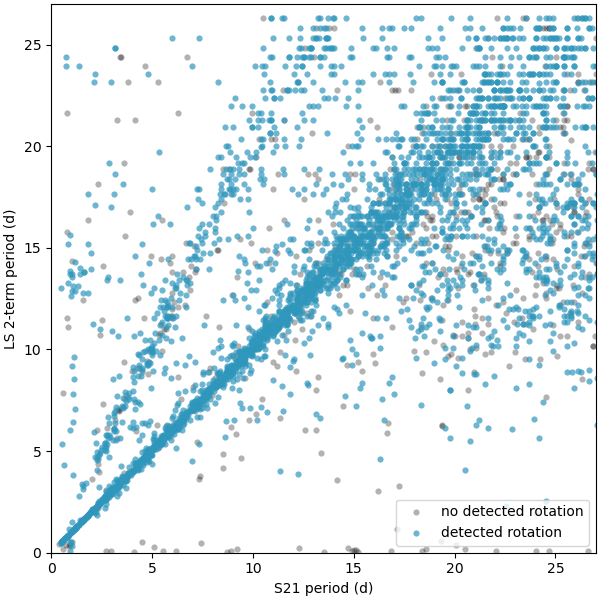

In [60]:
%matplotlib notebook

fig, ax = plt.subplots(1, constrained_layout=True, figsize=(6,6))

ax.scatter(p_r_test[(predictions==0)&(p_r_test>0)], ls2_a_test[(predictions==0)&(p_r_test>0)], 
           c='k', alpha=0.3, s=20, lw=0, label='no detected rotation')
ax.scatter(p_r_test[(predictions==1)&(p_r_test>0)], ls2_a_test[(predictions==1)&(p_r_test>0)], 
           c='#2f96bc', alpha=0.7, s=20, lw=0, label='detected rotation')
ax.set(xlim=(0, 27), ylim=(0,27), xlabel='S21 period (d)', ylabel='LS 2-term period (d)')
ax.legend(loc='lower right')

<IPython.core.display.Javascript object>


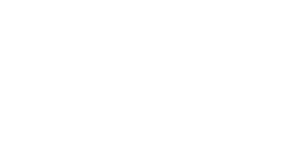

In [54]:
%matplotlib notebook

fig, ax = plt.subplots(1, constrained_layout=True, figsize=(6,6))

ax.scatter(p_r_test[(predictions_g==0)&(p_r_test>0)], ls2_a_test[(predictions_g==0)&(p_r_test>0)], 
           c='#000', alpha=0.3, s=20, lw=0, label='bad periods')
ax.scatter(p_r_test[(predictions_g==1)&(p_r_test>0)], ls2_a_test[(predictions_g==1)&(p_r_test>0)], 
           c='#2f96bc', alpha=0.7, s=20, lw=0, label='good periods')
ax.set(xlim=(0, 27), ylim=(0,27), xlabel='S21 period (d)', ylabel='LS 2-term period (d)')
ax.legend(loc='lower right')

<IPython.core.display.Javascript object>


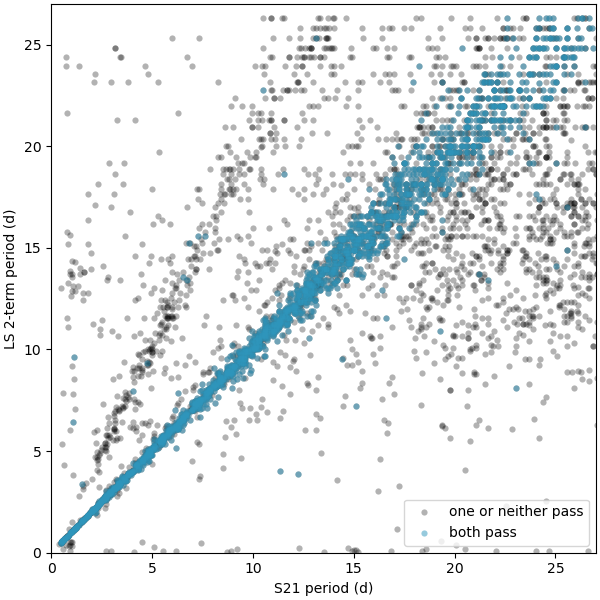

In [59]:
%matplotlib notebook

fig, ax = plt.subplots(1, constrained_layout=True, figsize=(6,6))

ax.scatter(p_r_test[p_r_test>0], ls2_a_test[p_r_test>0], c='k', alpha=0.3, s=20, lw=0, label='one or neither pass')
ax.scatter(p_r_test[(predictions==1)&(predictions_g==1)&(p_r_test>0)], 
           ls2_a_test[(predictions==1)&(predictions_g==1)&(p_r_test>0)], c='#2f96bc', alpha=0.5, s=20, lw=0, 
           label='both pass')
ax.set(xlim=(0,27), ylim=(0,27), xlabel='S21 period (d)', ylabel='LS 2-term period (d)')
ax.legend(loc='lower right')

In [56]:
len(p_r_test[(predictions==1)&(predictions_g==1)])/len(p_r_test)

0.1373686365497475

In [57]:
len(p_r_test[(predictions==1)&(predictions_g==1)&(p_r_test>0)])/len(p_r_test)

0.12481233792821073

In [58]:
0.1252997191203672 / 0.13797355621018018

0.9081429990069513